<a href="https://colab.research.google.com/github/JazmineOrtizMarin/Simulaci-n-2/blob/main/Proyecto_Este_Si_Es_El_Bueno_Simulacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto de Simulación: Clínica con Servidores en Serie
## Modelo de Red de Colas (Recepción $\to$ Consultorio)

### 1. Descripción del Problema
Este proyecto modela el flujo de pacientes en una clínica mediante una **Simulación de Eventos Discretos (DES)** implementada en Python con `SimPy`.

El sistema se comporta como una **red de colas en serie** (Tandem Queue) con dos estaciones:
1.  **Recepción:** El paciente llega, hace fila y se registra.
2.  **Consultorio:** Tras salir de recepción, el paciente pasa inmediatamente a la sala de espera de los doctores para ser atendido.

### 2. Objetivos
* Simular el comportamiento estocástico de llegadas y tiempos de servicio.
* Calcular métricas de desempeño ($W$, $L$, $\rho$) mediante simulación.
* **Validar** los resultados comparándolos con un modelo matemático teórico usando `SymPy`.
* Visualizar la evolución de las colas en el tiempo.

### 3. Fundamento Teórico: Redes de Jackson

Para el análisis teórico, asumimos que el sistema es una **Red de Jackson Abierta**. Dado que las llegadas son de tipo Poisson y los servicios son exponenciales, el teorema de Burke establece que la salida de la primera etapa (Recepción) también sigue un proceso de Poisson.

Esto nos permite descomponer el sistema en nodos independientes $M/M/c$:

1.  **Nodo 1 (Recepción):** Se modela como un sistema $M/M/c_1$ con tasa de llegada $\lambda$.
2.  **Nodo 2 (Doctores):** Se modela como un sistema $M/M/c_2$ donde la tasa de llegada es la misma $\lambda$ (suponiendo que no hay pérdidas entre etapas).

#### Fórmulas del Modelo M/M/c
Para cada estación, calculamos la probabilidad de estado vacío ($P_0$) y la longitud promedio de la fila ($L_q$) usando las fórmulas estándar:

$$P_0 = \left[ \sum_{n=0}^{c-1} \frac{(\lambda/\mu)^n}{n!} + \frac{(\lambda/\mu)^c}{c!(1-\rho)} \right]^{-1}$$

$$L_q = \frac{P_0 (\lambda/\mu)^c \rho}{c!(1-\rho)^2}$$

El tiempo total en el sistema ($W_{total}$) es la suma de los tiempos en cada etapa:
$$W_{total} = W_{recepción} + W_{doctor}$$

In [28]:
!pip install simpy
import simpy
import random
import statistics
import sympy as sp
import matplotlib.pyplot as plt
from dataclasses import dataclass

### 4. Implementación de la Simulación

Se utilizan las siguientes estructuras:
* **Clase `Escenario`:** Un `dataclass` que almacena los parámetros de configuración ($\lambda, \mu, c$).
* **Clase `ClinicaSerial`:** Representa el entorno físico. Contiene los recursos (`simpy.Resource`) para recepcionistas y doctores.
* **Proceso `atender_paciente`:** Define la lógica secuencial que sigue cada entidad:
    1.  Solicitar Recepcionista $\to$ Esperar $\to$ Ser atendido.
    2.  Liberar Recepcionista.
    3.  Solicitar Doctor $\to$ Esperar $\to$ Ser atendido.
    4.  Liberar Doctor $\to$ Salir.

In [29]:
@dataclass
class Escenario:
    lam: float  # Tasa de llegadas (Pacientes/hora)
    mu_recepcion: float  # Tasa servicio Recepción (Pacientes/hora)
    c_recepcion: int  # Num. Recepcionistas
    mu_doctor: float  # Tasa servicio Doctor (Pacientes/hora)
    c_doctor: int  # Num. Doctores

class ClinicaSerial:
    def __init__(self, env, escenario):
        self.env = env
        self.escenario = escenario

        # RECURSOS (SERVIDORES EN SERIE)
        self.recepcionistas = simpy.Resource(env, capacity=escenario.c_recepcion)
        self.doctores = simpy.Resource(env, capacity=escenario.c_doctor)

        # MÉTRICAS
        self.tiempos_sistema = [] # Tiempo total desde que llega hasta que se va

        # Monitores de cola (para gráficas)
        self.monitor_t = []
        self.cola_recep = []
        self.cola_doc = []

    def atender_paciente(self, pid):
        llegada = self.env.now

        # ETAPA 1: RECEPCIÓN (Pedir Cita/Turno)
        with self.recepcionistas.request() as req:
            yield req
            # Servicio Recepción
            yield self.env.timeout(random.expovariate(self.escenario.mu_recepcion))

        # ETAPA 2: CONSULTORIO (Atención Médica)
        # El paciente pasa inmediatamente de recepción a la cola de doctores
        with self.doctores.request() as req:
            yield req
            # Servicio Doctor
            yield self.env.timeout(random.expovariate(self.escenario.mu_doctor))

        # SALIDA
        self.tiempos_sistema.append(self.env.now - llegada)

### 5. Lógica de Procesos y Ejecución de la Simulación

En `SimPy`, la simulación avanza mediante la interacción de **procesos** (funciones generadoras de Python). Para este modelo, hemos definido tres componentes clave que orquestan el flujo del tiempo y la recolección de datos:

#### A. Generador de Pacientes (`generador_pacientes`)
Este proceso modela la llegada exógena de pacientes a la clínica.
* **Fundamento:** Utiliza una distribución **Exponencial** para los tiempos entre llegadas ($1/\lambda$), lo que genera un **Proceso de Poisson**.
* **Funcionamiento:** Crea una entidad (paciente) y desencadena su ciclo de vida (`atender_paciente`) repetidamente hasta que termina el tiempo de simulación.

#### B. Monitor de Estado (`observador_colas`)
Dado que la simulación ocurre en tiempo continuo (eventos discretos), necesitamos "tomar fotos" del sistema a intervalos regulares para poder graficar la evolución temporal.
* **Muestreo:** Cada 0.5 horas (o el intervalo definido), registra el tamaño de la fila en Recepción y en Consultorios.
* **Propósito:** Estos datos alimentan las gráficas de líneas, permitiendo observar picos de congestión y el comportamiento transitorio del sistema.

#### C. Orquestador (`ejecutar_simulacion`)
Es la función principal que inicializa el entorno (`simpy.Environment`), crea los recursos limitados (Recepcionistas y Doctores) y arranca los procesos anteriores.

In [30]:
def generador_pacientes(env, clinica):
    pid = 0
    while True:
        yield env.timeout(random.expovariate(clinica.escenario.lam))
        pid += 1
        env.process(clinica.atender_paciente(pid))

def observador_colas(env, clinica):
    while True:
        clinica.monitor_t.append(env.now)
        clinica.cola_recep.append(len(clinica.recepcionistas.queue))
        clinica.cola_doc.append(len(clinica.doctores.queue))
        yield env.timeout(0.5) # Muestrear cada media hora

def ejecutar_simulacion(escenario, tiempo_sim):
    print(f"Simulación Serial ({tiempo_sim} hrs):")
    env = simpy.Environment()
    clinica = ClinicaSerial(env, escenario)

    env.process(generador_pacientes(env, clinica))
    env.process(observador_colas(env, clinica))

    env.run(until=tiempo_sim)
    return clinica

### 6. Validación Teórica Automatizada (Módulo SymPy)

Para garantizar la precisión de los cálculos teóricos y evitar errores de redondeo en las sumatorias complejas, implementamos un módulo de cálculo simbólico/numérico.

#### Metodología de Descomposición
Basándonos en la teoría de **Redes de Jackson**, el código no intenta resolver una única ecuación gigante para toda la clínica. En su lugar, utiliza una estrategia de "Divide y Vencerás":

1.  **Abstracción Modular:** La función `calcular_mmc_individual` actúa como una "calculadora universal" para cualquier nodo $M/M/c$.
    * Calcula $P_0$ (Probabilidad de vacío) sumando los términos de la serie con precisión arbitraria.
    * Deriva $L_q$ (Longitud media de cola) basándose en $P_0$ y la intensidad de tráfico $\rho$.
    * Aplica la **Ley de Little** ($L = \lambda W$) para obtener el resto de métricas.

2.  **Agregación de Resultados:** La función `reporte_teorico_serial` invoca a la calculadora para cada etapa (Recepción y Doctores) y suma los tiempos resultantes.
    * $$W_{total} = W_{nodo1} + W_{nodo2}$$
    * $$L_{total} = L_{nodo1} + L_{nodo2}$$

Este enfoque permite validar que la simulación converge a los valores exactos esperados por la teoría de colas.

In [31]:
def calcular_mmc_individual(lam_val, mu_val, c_val, nombre):
    """Calcula métricas para un solo nodo M/M/c"""
    lam, mu, c = sp.symbols('lambda mu c')
    r = lam / mu
    rho = r / c

    # Validación Estabilidad
    rho_num = lam_val / (c_val * mu_val)
    if rho_num >= 1:
        return None

    # P0
    suma = sum([((lam_val/mu_val)**i)/sp.factorial(i) for i in range(c_val)])
    term_c = ((lam_val/mu_val)**c_val)/(sp.factorial(c_val)*(1 - (lam_val/(c_val*mu_val))))
    p0 = 1 / (suma + term_c)

    # Lq
    lq = p0 * ( ((lam_val/mu_val)**c_val * (lam_val/(c_val*mu_val))) / (sp.factorial(c_val) * (1 - (lam_val/(c_val*mu_val)))**2) )

    # Ley de Little
    wq = lq / lam_val
    w = wq + (1/mu_val)
    l = lam_val * w

    return {"W": float(w), "L": float(l), "Rho": rho_num}

def reporte_teorico_serial(esc):
    print("\n" + "="*40)
    print("      ANÁLISIS TEÓRICO (SERIE)")
    print("="*40)

    # Nodo 1: Recepción
    res_recep = calcular_mmc_individual(esc.lam, esc.mu_recepcion, esc.c_recepcion, "Recepción")
    # Nodo 2: Doctor (La entrada es la salida de Recepción = Lambda)
    res_doc = calcular_mmc_individual(esc.lam, esc.mu_doctor, esc.c_doctor, "Doctor")

    if not res_recep or not res_doc:
        print("ERROR: Alguna estación es inestable (Rho >= 1)")
        return None

    # Totales del Sistema (Suma de tiempos y promedios)
    w_total = res_recep["W"] + res_doc["W"]
    l_total = res_recep["L"] + res_doc["L"] # L es aditiva en redes Jackson

    print(f"Recepción Rho: {res_recep['Rho']:.2%}")
    print(f"Doctores Rho:  {res_doc['Rho']:.2%}")
    print("=" * 40)
    return {"W_total": w_total, "L_total": l_total}

In [32]:
def graficar_resultados(clinica):
    plt.figure(figsize=(12, 5))
    plt.plot(clinica.monitor_t, clinica.cola_recep, label="Cola Recepción", alpha=0.7)
    plt.plot(clinica.monitor_t, clinica.cola_doc, label="Cola Doctores", alpha=0.7)
    plt.title("Evolución de las Colas (Recepción -> Doctor)")
    plt.xlabel("Tiempo (h)")
    plt.ylabel("Personas")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

def comparar_resultados(sim, teorico, lam):
    if not sim.tiempos_sistema:
        print("Sin pacientes.")
        return

    sim_w = statistics.mean(sim.tiempos_sistema)
    sim_l = lam * sim_w # Little empírico

    print("\n" + "-"*60)
    print(f"{'MÉTRICA GLOBAL':<20} | {'SIMULACIÓN':<12} | {'TEÓRICO':<12} | {'ERROR %':<10}")
    print("-"*60)

    datos = [
        ("W Total (Tiempo)", sim_w, teorico["W_total"]),
        ("L Total (Gente)", sim_l, teorico["L_total"])
    ]

    for nom, s, t in datos:
        err = abs(s - t) / t * 100
        print(f"{nom:<20} | {s:<12.4f} | {t:<12.4f} | {err:<10.2f}")
    print("-"*60)

# Proyecto Final: Simulación de Clínica (Red de Colas)

## 1. Ejercicio
Se desea modelar y simular el funcionamiento de una pequeña clínica médica que opera bajo un esquema de **servidores en serie**. El flujo de pacientes consta de dos etapas obligatorias:

1.  **Recepción (Etapa 1):** Los pacientes llegan y deben registrarse.
2.  **Consultorio (Etapa 2):** Una vez registrados, pasan a una sala de espera para ser atendidos por uno de los doctores disponibles.

**Parámetros del Sistema:**
* **Llegadas ($\lambda$):** Los pacientes llegan con una tasa media de **10 pacientes por hora** (Proceso de Poisson).
* **Recepción (Nodo 1):**
    * Cuenta con **1 recepcionista** ($c_1 = 1$).
    * Tiempo medio de atención: **4 minutos** ($\mu_1 = 15$ pac/hora).
* **Consultorio (Nodo 2):**
    * Cuenta con **3 doctores** ($c_2 = 3$).
    * Tiempo medio de consulta: **15 minutos** ($\mu_2 = 4$ pac/hora).

**Objetivo:** Determinar el tiempo promedio total que un paciente pasa en la clínica ($W_{total}$) y el número promedio de pacientes en el establecimiento ($L_{total}$).


      ANÁLISIS TEÓRICO (SERIE)
Recepción Rho: 66.67%
Doctores Rho:  83.33%
Simulación Serial (3000 hrs):

------------------------------------------------------------
MÉTRICA GLOBAL       | SIMULACIÓN   | TEÓRICO      | ERROR %   
------------------------------------------------------------
W Total (Tiempo)     | 0.8039       | 0.8011       | 0.34      
L Total (Gente)      | 8.0388       | 8.0112       | 0.34      
------------------------------------------------------------


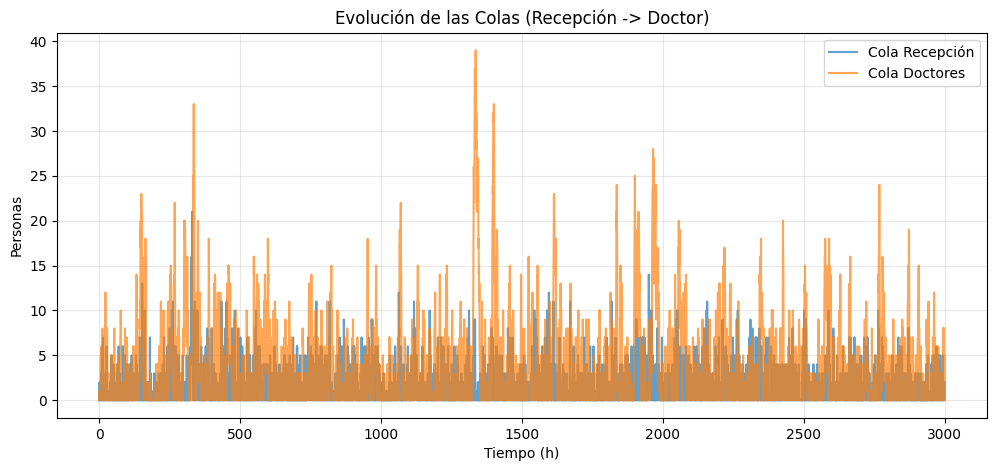

In [34]:
if __name__ == "__main__":
    # PARÁMETROS DEL EJERCICIO
    PARAMS = Escenario(
        lam=10.0,   # Llegan 10 pacientes/hora
        mu_recepcion=15.0, # 1 Recepcionista atiende 15/hora (rápido)
        c_recepcion=1,  # 1 Recepcionista
        mu_doctor=4.0,  # 1 Doctor atiende 4/hora (lento)
        c_doctor=3   # 3 Doctores
    )
    TIEMPO = 3000 # Horas

    # 1. Teoría
    teoricos = reporte_teorico_serial(PARAMS)

    if teoricos:
        # 2. Simulación
        clinica_sim = ejecutar_simulacion(PARAMS, TIEMPO)

        # 3. Comparación
        comparar_resultados(clinica_sim, teoricos, PARAMS.lam)

        # 4. Gráficas
        graficar_resultados(clinica_sim)

## 2. Cálculo Manual

Para validar la simulación, calculamos teóricamente los valores esperados descomponiendo la red en dos nodos independientes (Teorema de Burke).

### A. Análisis de Recepción (Modelo M/M/1)
* $\lambda = 10$, $\mu = 15$, $c = 1$
* Intensidad de tráfico: $\rho_1 = \lambda / \mu = 10/15 = 0.667$ (Sistema estable $< 1$)

**Métricas:**
* $L_1 = \frac{\rho}{1-\rho} = \frac{0.667}{0.333} = \mathbf{2.00 \text{ pacientes}}$
* $W_1 = \frac{L}{\lambda} = \frac{2}{10} = \mathbf{0.20 \text{ horas}}$ (12 mins)

---

### B. Análisis de Consultorios (Modelo M/M/3)
* $\lambda = 10$, $\mu = 4$, $c = 3$
* $r = \lambda/\mu = 2.5$
* Intensidad de tráfico: $\rho_2 = r/c = 2.5/3 = 0.833$ (Sistema estable $< 1$)

**1. Probabilidad de vacío ($P_0$):**
$$P_0 = \left[ \frac{2.5^0}{0!} + \frac{2.5^1}{1!} + \frac{2.5^2}{2!} + \frac{2.5^3}{3!(1-0.833)} \right]^{-1}$$
$$P_0 = \left[ 1 + 2.5 + 3.125 + 15.625 \right]^{-1} = (22.25)^{-1} \approx \mathbf{0.0449}$$

**2. Longitud de Cola ($L_q$):**
$$L_q = \frac{P_0 \cdot r^c \cdot \rho}{c!(1-\rho)^2} = \frac{0.0449 \cdot 15.625 \cdot 0.833}{6 \cdot (0.166)^2} \approx \mathbf{3.51 \text{ pac}}$$

**3. Tiempos y Sistema:**
* $W_{q2} = L_q / \lambda = 0.351 \text{ horas}$
* $W_2 = W_{q2} + 1/\mu = 0.351 + 0.25 = \mathbf{0.601 \text{ horas}}$
* $L_2 = \lambda \cdot W_2 = \mathbf{6.01 \text{ pacientes}}$

---

### C. Totales del Sistema (Resultados Esperados)
Sumando ambas etapas, esperamos que la simulación converja a:

* **Tiempo Total en Clínica ($W_{total}$):** $0.20 + 0.601 = \mathbf{0.8011 \text{ horas}}$
* **Pacientes en Clínica ($L_{total}$):** $2.00 + 6.01 = \mathbf{8.011 \text{ pacientes}}$